In [1]:
import os
import random
import shutil
import numpy as np
from scipy import misc
from skimage import morphology, measure
from sklearn.cluster import KMeans
from scipy.ndimage.morphology import distance_transform_edt as dist_transform
import glob
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_folder(folder):
    if not os.path.exists(folder):
        os.mkdir(folder)

In [3]:
dataset_r = 'DSB2018plus'  # LC: Lung Cancer, MO: MultiOrgan
subset = 'stage_1_train'
if subset != None:
    dataset = os.path.join(dataset_r, subset)
else:
    dataset = dataset_r

data_dir = '../cell_data/{:s}'.format(dataset)
img_dir = data_dir
label_instance_dir = './data/{:s}/labels_instance'.format(dataset)
label_point_dir = './data/{:s}/labels_point'.format(dataset)
label_vor_dir = './data/{:s}/labels_voronoi'.format(dataset)
label_cluster_dir = './data/{:s}/labels_cluster'.format(dataset)
patch_folder = './data/{:s}/patches'.format(dataset)
train_data_dir = './data_for_train/{:s}'.format(dataset)
create_folder(label_instance_dir)
create_folder('./data')
create_folder('./data/{:s}'.format(dataset_r))
create_folder('./data/{:s}'.format(dataset))
create_folder('./data_for_train')
create_folder('./data_for_train/{:s}'.format(dataset_r))
create_folder('./data_for_train/{:s}'.format(dataset))
create_folder(label_point_dir)
create_folder(label_vor_dir)
create_folder(label_cluster_dir)
create_folder(patch_folder)
create_folder(train_data_dir)

#image_list = os.listdir(data_dir)

#seed = 448
#random.seed(seed)
#random.shuffle(image_list)

#train = image_list[:int(len(image_list)*0.8)]
#valid = image_list[int(len(image_list)*0.8):int(len(image_list)*0.9)]
#test = image_list[int(len(image_list)*0.9):]

#data_list = {'train': train, 'val': valid, 'test': test}
#with open('./data/{:s}/train_val_test.json'.format(dataset), 'w') as file:
#    json.dump(data_list, file)
with open('./data/{:s}/train_val_test.json'.format(dataset), 'r') as file:
    data_list = json.load(file)
    train_list = data_list['train']

In [4]:
def create_labels_instance(data_dir, dataset, save_dir):
    
    with open('./data/{:s}/train_val_test.json'.format(dataset), 'r') as file:
        data_list = json.load(file)
        train_list = data_list['train']
    
    image_list = os.listdir(data_dir)
    for image_name in image_list:
        image_path = os.path.join(data_dir, image_name)
        mask_list = glob.glob(image_path + '/masks/*.png')
        if len(mask_list)<4 and mask_list in train_list:
            print(mask_list)
            train_list.remove(mask_list)
            continue
        masks=[]
        for i, mask_file in enumerate(mask_list):
            mask = misc.imread(mask_file)
            masks.append(mask*(i+1))
        masks = np.stack(masks, axis=-1)
        masks = np.sum(masks, axis=-1)
        misc.imsave('{:s}/{:s}_label.png'.format(save_dir, image_name), masks.astype(np.uint8))
    with open('./data/{:s}/train_val_test.json'.format(dataset), 'w') as file:
        json.dump(data_list, file)

In [5]:
create_labels_instance(data_dir, dataset, label_instance_dir)

/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [6]:
#with open('./data/{:s}/train_val_test.json'.format(dataset), 'r') as file:
#    data_list = json.load(file)
#    train_list = data_list['train']

In [7]:
#train_list.remove('93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77')
#train_list.remove('220b37f4ca7cab486d2b71cd87a46ee7411a5aa142799d96ed98015ab5ba538a')
#train_list.remove('e5aeb5b3577abbebe8982b5dd7d22c4257250ad3000661a42f38bf9248d291fd')

In [8]:
#with open('./data/{:s}/train_val_test.json'.format(dataset), 'w') as file:
#    json.dump(data_list, file)

# create point label from instance

In [9]:
def create_point_label_from_instance(data_dir, save_dir, train_list):
    def get_point(img):
        a = np.where(img != 0)
        rmin, rmax, cmin, cmax = np.min(a[0]), np.max(a[0]), np.min(a[1]), np.max(a[1])
        return (rmin + rmax) // 2, (cmin + cmax) // 2

    print("Generating point label from instance label...")
    image_list = os.listdir(data_dir)
    N_total = len(train_list)
    N_processed = 0
    for image_name in image_list:
        name = image_name.split('.')[0]
        if name[:-6] not in train_list or name[-5:] != 'label':
            continue
        N_processed += 1
        flag = '' if N_processed < N_total else '\n'
        print('\r\t{:d}/{:d}'.format(N_processed, N_total), end=flag)

        image_path = os.path.join(data_dir, image_name)
        image = misc.imread(image_path)
        h, w = image.shape

        # extract bbox
        id_max = np.max(image)
        label_point = np.zeros((h, w), dtype=np.uint8)

        for i in range(1, id_max + 1):
            nucleus = image == i
            if np.sum(nucleus) == 0:
                continue
            x, y = get_point(nucleus)
            label_point[x, y] = 255

        misc.imsave('{:s}/{:s}_point.png'.format(save_dir, name), label_point.astype(np.uint8))

In [10]:
label_points = create_point_label_from_instance(label_instance_dir, label_point_dir, train_list)

Generating point label from instance label...
	2/528

/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:34: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


	528/528


# Create Voronoi label

In [13]:
def create_Voronoi_label(data_dir, save_dir, train_list):
    from scipy.spatial import Voronoi
    from shapely.geometry import Polygon
    from utils import voronoi_finite_polygons_2d, poly2mask
    img_list = os.listdir(data_dir)

    print("Generating Voronoi label from point label...")
    N_total = len(train_list)
    N_processed = 0
    for img_name in sorted(img_list):
        name = img_name.split('.')[0]
        if name[:-12] not in train_list:
            continue

        N_processed += 1
        flag = '' if N_processed < N_total else '\n'
        print('\r\t{:d}/{:d}'.format(N_processed, N_total), end=flag)

        img_path = '{:s}/{:s}'.format(data_dir, img_name)
        
        label_point = misc.imread(img_path)
        h, w = label_point.shape

        points = np.argwhere(label_point > 0)
        vor = Voronoi(points)

        regions, vertices = voronoi_finite_polygons_2d(vor)
        box = Polygon([[0, 0], [0, w], [h, w], [h, 0]])
        region_masks = np.zeros((h, w), dtype=np.int16)
        edges = np.zeros((h, w), dtype=np.bool)
        count = 1
        for region in regions:
            polygon = vertices[region]
            # Clipping polygon
            poly = Polygon(polygon)
            poly = poly.intersection(box)
            polygon = np.array([list(p) for p in poly.exterior.coords])

            mask = poly2mask(polygon[:, 0], polygon[:, 1], (h, w))
            edge = mask * (~morphology.erosion(mask, morphology.disk(1)))
            edges += edge
            region_masks[mask] = count
            count += 1

        # fuse Voronoi edge and dilated points
        label_point_dilated = morphology.dilation(label_point, morphology.disk(2))
        label_vor = np.zeros((h, w, 3), dtype=np.uint8)
        label_vor[:, :, 0] = (edges > 0).astype(np.uint8) * 255
        label_vor[:, :, 1] = (label_point_dilated > 0).astype(np.uint8) * 255

        name = img_name.split('.')[0]
        #misc.imsave('{:s}/{:s}_label_vor.png'.format(save_dir, name[:-12]), label_vor)
        plt.imshow(label_vor)
        break

Generating Voronoi label from point label...
	1/528

/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


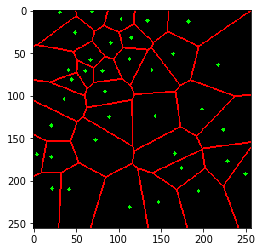

In [14]:
create_Voronoi_label(label_point_dir, label_vor_dir, train_list)

# Create cluster label

In [21]:
def create_cluster_label(data_dir, label_point_dir, label_vor_dir, save_dir, train_list):
    from scipy.ndimage import morphology as ndi_morph
    img_list = os.listdir(data_dir)
    print("Generating cluster label from point label...")
    
    for img_name in sorted(img_list):
        if img_name not in train_list:
            continue
        ori_image_path = os.path.join(data_dir, img_name)        
        # print('\t[{:d}/{:d}] Processing image {:s} ...'.format(count, len(img_list), img_name))
        ori_image = misc.imread('{:s}/{:s}/image/{:s}.png'.format(data_dir, img_name, img_name))
        h, w, _ = ori_image.shape
        
        label_point = misc.imread('{:s}/{:s}_label_point.png'.format(label_point_dir, img_name))
        # k-means clustering
        dist_embeddings = dist_transform(255 - label_point).reshape(-1, 1)
        clip_dist_embeddings = np.clip(dist_embeddings, a_min=0, a_max=20)
        color_embeddings = np.array(ori_image, dtype=np.float).reshape(-1, 3) / 10
        embeddings = np.concatenate((color_embeddings, clip_dist_embeddings), axis=1)

        # print("\t\tPerforming k-means clustering...")
        kmeans = KMeans(n_clusters=3, random_state=0).fit(embeddings)
        clusters = np.reshape(kmeans.labels_, (h, w))

        # get nuclei and background clusters
        overlap_nums = [np.sum((clusters == i) * label_point) for i in range(3)]
        nuclei_idx = np.argmax(overlap_nums)
        remain_indices = np.delete(np.arange(3), nuclei_idx)
        dilated_label_point = morphology.binary_dilation(label_point, morphology.disk(5))
        overlap_nums = [np.sum((clusters == i) * dilated_label_point) for i in remain_indices]
        background_idx = remain_indices[np.argmin(overlap_nums)]

        nuclei_cluster = clusters == nuclei_idx
        background_cluster = clusters == background_idx
        # overlap_nums = [np.sum((clusters == i) * label_point) for i in range(3)]
        # nuclei_idx = np.argmax(overlap_nums)
        # nuclei_cluster = clusters == nuclei_idx
        # nuclei_cluster = ndi_morph.binary_fill_holes(nuclei_cluster)
        #
        # # get background cluster
        # remain_indices = np.delete(np.arange(3), nuclei_idx)
        # dilated_nuclei_cluster = morphology.binary_dilation(nuclei_cluster, morphology.disk(3))
        # overlap_nums = [np.sum((clusters == i) * dilated_nuclei_cluster) for i in remain_indices]
        # background_idx = remain_indices[np.argmin(overlap_nums)]
        # background_cluster = clusters == background_idx

        # refine clustering results
        # print("\t\tRefining clustering results...")
        nuclei_labeled = measure.label(nuclei_cluster)
        initial_nuclei = morphology.remove_small_objects(nuclei_labeled, 30)
        refined_nuclei = np.zeros(initial_nuclei.shape, dtype=np.bool)

        label_vor = misc.imread('{:s}/{:s}_label_vor.png'.format(label_vor_dir, img_name))
        voronoi_cells = measure.label(label_vor[:, :, 0] == 0)
        voronoi_cells = morphology.dilation(voronoi_cells, morphology.disk(2))

        unique_vals = np.unique(voronoi_cells)
        cell_indices = unique_vals[unique_vals != 0]
        N = len(cell_indices)
        for i in range(N):
            cell_i = voronoi_cells == cell_indices[i]
            nucleus_i = cell_i * initial_nuclei

            nucleus_i_dilated = morphology.binary_dilation(nucleus_i, morphology.disk(5))
            nucleus_i_dilated_filled = ndi_morph.binary_fill_holes(nucleus_i_dilated)
            nucleus_i_final = morphology.binary_erosion(nucleus_i_dilated_filled, morphology.disk(7))
            refined_nuclei += nucleus_i_final > 0

        refined_label = np.zeros((h, w, 3), dtype=np.uint8)
        label_point_dilated = morphology.dilation(label_point, morphology.disk(10))
        refined_label[:, :, 0] = (background_cluster * (refined_nuclei == 0) * (label_point_dilated == 0)).astype(np.uint8) * 255
        refined_label[:, :, 1] = refined_nuclei.astype(np.uint8) * 255
        plt.figure(figsize=(10,10))
        plt.imshow(refined_label)
        plt.show()
        break

Generating cluster label from point label...


/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/home/vincentwu-cmlab/miniconda3/envs/ammai/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


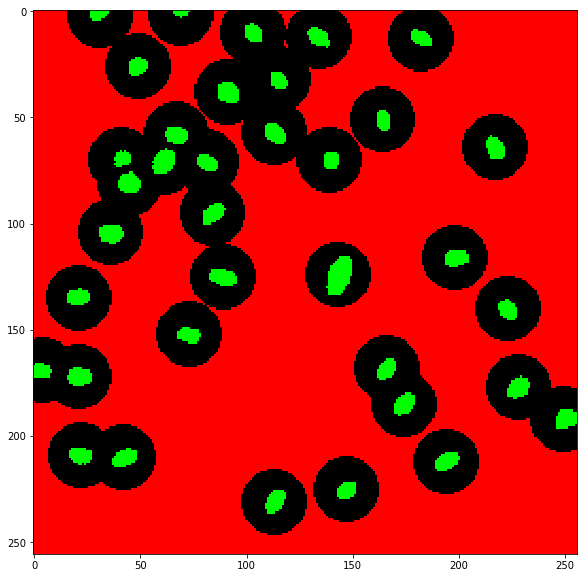

In [22]:
create_cluster_label(img_dir, label_point_dir, label_vor_dir, label_cluster_dir, train_list)

# Split patches

In [25]:
def split_patches(data_dir, save_dir, post_fix=None):
    import math
    """ split large image into small patches """
    create_folder(save_dir)
    
    image_list = os.listdir(data_dir)
    for image_name in image_list:
        name = image_name.split('.')[0]
        if post_fix:
            image_path = '{:s}/{:s}.png'.format(data_dir, name)

        else:
            image_path = '{:s}/{:s}/image/{:s}.png'.format(data_dir, name, name)

        
        image = misc.imread(image_path)
        seg_imgs = []
        
        # split into 16 patches of size 250x250
        h, w = image.shape[0], image.shape[1]
        patch_size = 250
        h_overlap = math.ceil((4 * patch_size - h) / 3)
        w_overlap = math.ceil((4 * patch_size - w) / 3)
        for i in range(0, h-patch_size+1, patch_size-h_overlap):
            for j in range(0, w-patch_size+1, patch_size-w_overlap):
                if len(image.shape) == 3:
                    patch = image[i:i+patch_size, j:j+patch_size, :]
                else:
                    patch = image[i:i + patch_size, j:j + patch_size]
                seg_imgs.append(patch)

        for k in range(len(seg_imgs)):
            if post_fix:
                misc.imsave('{:s}/{:s}_{:d}_{:s}.png'.format(save_dir, name[:-len(post_fix)-1], k, post_fix), seg_imgs[k])
            else:
                misc.imsave('{:s}/{:s}_{:d}.png'.format(save_dir, name, k), seg_imgs[k])

In [29]:
#split_patches(img_dir, '{:s}/images'.format(patch_folder))

In [30]:
#split_patches(label_vor_dir, '{:s}/labels_voronoi'.format(patch_folder), 'label_vor')

In [31]:
def organize_data_for_training(data_dir, dataset, train_data_dir):
    # --- Step 1: create folders --- #
    create_folder(train_data_dir)
    create_folder('{:s}/images'.format(train_data_dir))
    create_folder('{:s}/labels_voronoi'.format(train_data_dir))
    create_folder('{:s}/labels_cluster'.format(train_data_dir))
    create_folder('{:s}/images/train'.format(train_data_dir))
    create_folder('{:s}/images/val'.format(train_data_dir))
    create_folder('{:s}/images/test'.format(train_data_dir))
    create_folder('{:s}/labels_voronoi/train'.format(train_data_dir))
    create_folder('{:s}/labels_cluster/train'.format(train_data_dir))

    # --- Step 2: move images and labels to each folder --- #
    print('Organizing data for training...')
    with open('./data/{:s}/train_val_test.json'.format(dataset), 'r') as file:
        data_list = json.load(file)
        train_list, val_list, test_list = data_list['train'], data_list['val'], data_list['test']

    # train
    for img_name in train_list:
        name = img_name.split('.')[0]
        # images
        for file in glob.glob('./data/{:s}/patches/images/{:s}*'.format(dataset, name)):
            file_name = file.split('/')[-1]
            dst = '{:s}/images/train/{:s}'.format(train_data_dir, file_name)
            shutil.copyfile(file, dst)
        # label_voronoi
        for file in glob.glob('./data/{:s}/patches/labels_voronoi/{:s}*'.format(dataset, name)):
            file_name = file.split('/')[-1]
            dst = '{:s}/labels_voronoi/train/{:s}'.format(train_data_dir, file_name)
            shutil.copyfile(file, dst)
        # label_cluster
        for file in glob.glob('./data/{:s}/patches/labels_cluster/{:s}*'.format(dataset, name)):
            file_name = file.split('/')[-1]
            dst = '{:s}/labels_cluster/train/{:s}'.format(train_data_dir, file_name)
            shutil.copyfile(file, dst)
    # val
    for img_name in val_list:
        name = img_name.split('.')[0]
        print(name)
        ## images
        for file in glob.glob('{:s}/{:s}/image/*'.format(data_dir, name)):
            file_name = file.split('/')[-1]
            dst = '{:s}/images/val/{:s}'.format(train_data_dir, file_name)
            shutil.copyfile(file, dst)
    # test
    for img_name in test_list:
        name = img_name.split('.')[0]
        # images
        for file in glob.glob('{:s}/{:s}/image/*'.format(data_dir, name)):
            file_name = file.split('/')[-1]
            dst = '{:s}/images/test/{:s}'.format(train_data_dir, file_name)
            shutil.copyfile(file, dst)

In [33]:
#organize_data_for_training(data_dir, dataset, train_data_dir)